In [79]:
from load_data import load


# Load the data if not loaded
if 'sim_arr' not in locals() or 'parameters_dict' not in locals():
    sim_arr, parameters_dict, simulation_file_paths = load()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into train, test and validation sets
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(
    train_set, test_size=0.2, random_state=42)

In [80]:
# check gpu
import tensorflow as tf
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [81]:
import optuna

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

# get input shape from the data
input_shape = train_set.shape[1:]
output_shape = (1, 1, 12)


def create_model(trial):
    # Hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 4)

    filters = [trial.suggest_categorical(f'filters_{i}', [3, 6, 9, 12])
               for i in range(num_layers - 1)]
    filters.append(output_shape[-1])

    kernel_sizes = [trial.suggest_int(
        f'kernel_size{i}', 2, 8) for i in range(num_layers)]

    poolsize = [[16],
                [4, 4],
                [2, 2, 4],
                [2, 2, 2, 2]]

    # Encoder
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer(input_shape=input_shape))
    for i in range(num_layers):
        encoder.add(MaxPool2D(poolsize[num_layers - 1][i]))
        encoder.add(Conv2D(
            filters[i],
            kernel_sizes[i],
            strides=1,
            activation='selu',
            padding='same',
            kernel_initializer='lecun_normal')
        )
    encoder.add(MaxPool2D(5))

    # Decoder
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape=encoder.output_shape[1:]))
    for i in range(num_layers - 1, -1, -1):
        decoder.add(Conv2DTranspose(
            filters[i],
            kernel_sizes[i],
            strides=poolsize[num_layers - 1][i],
            activation='selu',
            padding='same'
        ))
    decoder.add(Conv2DTranspose(
        input_shape[-1],
        kernel_sizes[0],
        strides=5,
        activation='selu',
        padding='same'
    ))

    # Compile the model
    auto_encoder = Sequential([encoder, decoder], name="autoencoder")
    auto_encoder.compile(optimizer='adam', loss="MSE")

    return auto_encoder


def objective(trial):
    # Clear clutter from previous sessions
    tf.keras.backend.clear_session()

    # Create model
    model = create_model(trial)

    # Train the model
    history = model.fit(train_set, train_set, epochs=10, batch_size=32,
                        validation_data=(valid_set, valid_set), verbose=0)

    return history.history['val_loss'][-1]


# Perform hyperparameter optimization
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name='autoencoder_3',
                            storage='sqlite:///autoencoder_3.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-03-15 10:05:11,516] A new study created in RDB with name: autoencoder_3
/home/tux/optim/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
[I 2024-03-15 10:05:20,253] Trial 0 finished with value: 0.15229719877243042 and parameters: {'num_layers': 3, 'filters_0': 12, 'filters_1': 12, 'kernel_size_enc_0': 2, 'kernel_size_enc_1': 3, 'kernel_size_enc_2': 3}. Best is trial 0 with value: 0.15229719877243042.
[I 2024-03-15 10:05:29,165] Trial 1 finished with value: 0.013311464339494705 and parameters: {'num_layers': 3, 'filters_0': 6, 'filters_1': 6, 'kernel_size_enc_0': 5, 'kernel_size_enc_1': 5, 'kernel_size_enc_2': 7}. Best is trial 1 with value: 0.013311464339494705.
[I 2024-03-15 10:05:38,030] Trial 2 finished with value: 0.07484910637140274 and parameters: {'num_layers': 3, 'filters_0': 3, 'filters_1': 12, 'kernel_size_enc_0': 4, 'kernel_size_enc_1': 8, 'kernel_size_

Best hyperparameters: {'num_layers': 3, 'filters_0': 12, 'filters_1': 9, 'kernel_size_enc_0': 8, 'kernel_size_enc_1': 8, 'kernel_size_enc_2': 4}


In [84]:
# Train the model with the best hyperparameters
auto_encoder = create_model(study.best_trial)
history = auto_encoder.fit(train_set, train_set, epochs=10, batch_size=32,
                           validation_data=(valid_set, valid_set))

auto_encoder.evaluate(test_set, test_set)

/home/tux/optim/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1949 - val_loss: 0.0460
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0407 - val_loss: 0.0184
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0166 - val_loss: 0.0115
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0081
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0053
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0060


0.005997795611619949

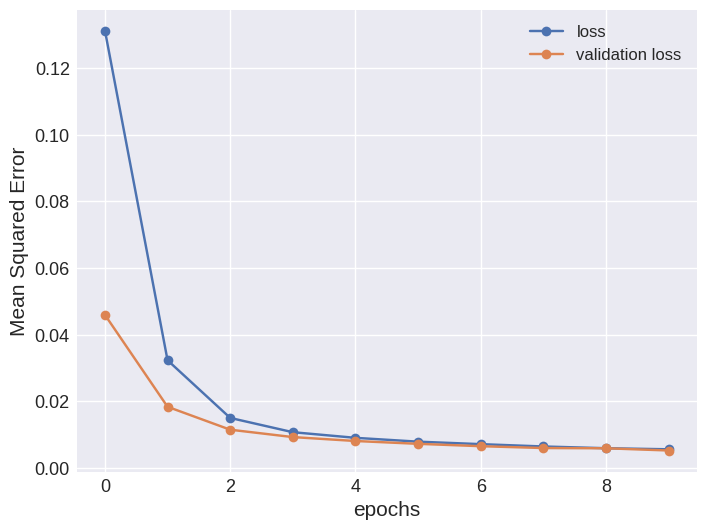

In [85]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

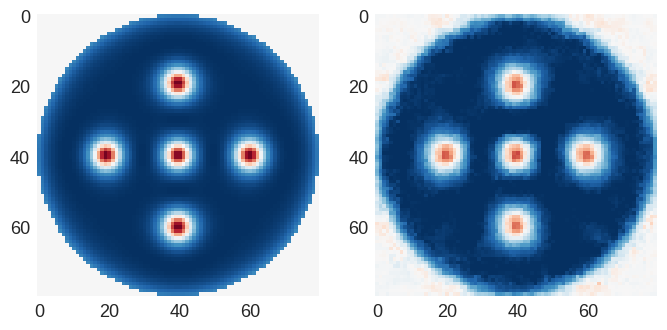

In [86]:
i = 25
in_sim = test_set[i: i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

In [89]:
from tensorflow.keras.layers import Flatten as Flatten

feature_extractor = Sequential(
    [
        auto_encoder.get_layer("encoder"),
        Flatten(),
    ]
)

feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 1s - 6ms/step


In [90]:
# Save the feature array
np.save("feature_arr.npy", feature_arr)